This is my solution for the skill test

In [62]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import multiprocessing as mp
from spacy import displacy

os.sys.path.append('./..')
from utils.loadgenius import DataLoader
from utils.pretty import pprint, plot_missing_values, plot_value_counts, generate_sample_history
from utils.consignee_extract import parse_string_to_dict
from utils.country_name_detect import get_model

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import hyperopt
from hyperopt.pyll import scope

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.manifold import TSNE

from utils.pretty import pprint
from functools import wraps



# Pointing the loader to the data loading instruction
dl = DataLoader('./../catalog.yml')

pprint(f"""Available dataset: \\
       {dl.list_datasets()}""")

Available dataset: \
       ['importer_normalized_data', 'main', 'ports', 'importers_cleaned', 'ports_cleaned', 'main_cleaned', 'ml_dataset']

In [2]:
%%time
# Loading in datasets
ports = dl.load('ports').drop('Unnamed: 0', axis=1)
main = dl.load('main').drop('Unnamed: 0', axis=1)
importer = dl.load('importer_normalized_data').drop('Unnamed: 0', axis=1)

CPU times: user 21.4 s, sys: 740 ms, total: 22.1 s
Wall time: 22.2 s


# Preprocessing datasets

# `importer_normalized_data.csv`: duplicated raw names

In [3]:
pprint("Some raw names are duplicated")
report = importer["importer_raw_name"].value_counts()
display(report[report > 1])

Some raw names are duplicated

importer_raw_name
MASONITE LAWRENCEVILLE DFS         2
ANATOLIA TILE & STONE, INC. 202    2
MASONITE LAWRENCEVILLE             2
SINTEX MINERALS                    2
METSO MINERALS WAUKESHA            2
Name: count, dtype: int64

Duplication example MASONITE LAWRENCEVILLE DFS:

In [4]:
importer.query('importer_raw_name=="MASONITE LAWRENCEVILLE DFS"')

,importer_rank,importer_raw_name,importer_deduped_name
21480,3354,MASONITE LAWRENCEVILLE DFS,MASONITE CORP
46134,9981,MASONITE LAWRENCEVILLE DFS,MASONITE LAWRENCEVILLE DFS


**Resolve:** Keep the row with highest rank 

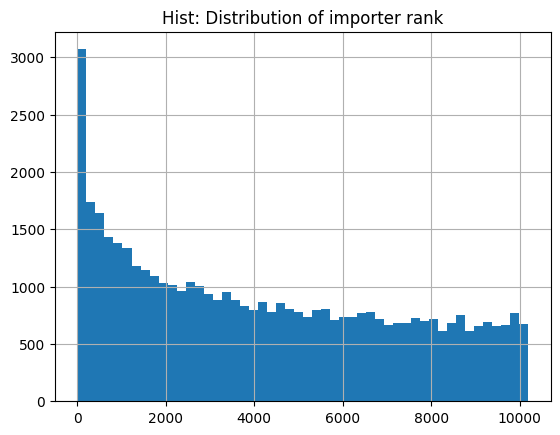

In [5]:
importer = importer.sort_values('importer_rank').drop_duplicates(subset=['importer_raw_name'], keep='first')
importer['importer_rank'].hist(bins=50)
plt.title("Hist: Distribution of importer rank");

It shows that above 5000, the distribution of ranks seems to be uniform.

## `ports.csv`: remove duplicates

In [6]:
print("ports: Rows before", ports.shape[0])
ports = (ports
         .drop_duplicates(subset=['port_code'])
         .reset_index(drop=True)
        )
print("ports: Rows after deduplication", ports.shape[0])

ports: Rows before 10927
ports: Rows after deduplication 2862


We only care about ports in `main.csv`:

Number of ports of interest = 97

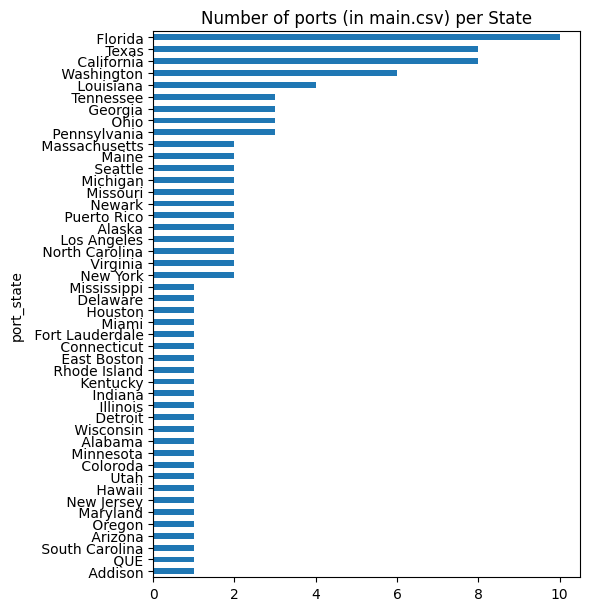

In [7]:
ports = ports[ports['port_code'].isin(set(main['port_of_unlading']))]
ports['port_state'] = ports['port_name'].str.split(',').apply(lambda x: x[1])
pprint(f"Number of ports of interest = {ports.shape[0]}")
ports['port_state'].value_counts()[::-1].plot.barh(figsize=(6, 6))
plt.tight_layout()
plt.title("Number of ports (in main.csv) per State");

## `main.csv`: extract important fields & drop duplicates

In [8]:
%%time
original_columns = main.columns

with mp.Pool() as pool:
    result = pool.map(parse_string_to_dict, main['consignee'])
    
main['extracted'] = result
del(result)

CPU times: user 38.7 s, sys: 8.02 s, total: 46.7 s
Wall time: 1min 7s


In [9]:
# Double check if the extraction fails on any record
if any(main['extracted'].isna()):
    pprint("Extraction failed somewhere")
else:
    pprint("Extraction is successful")
    

Extraction is successful

Extract further on `cleaned_address_breakdown`

In [10]:
%%time
# Extract information in cleaned address
address_bits = ['address_number',
                 'country_name',
                 'place_name',
                 'state_name',
                 'street_name',
                 'street_name_post_type',
                 'street_name_pre_directional',
                 'street_name_pre_type',
                 'zip_code']

for bit in address_bits:
    main[bit] = main['extracted'].apply(lambda x: x['cleaned_address_breakdown'].get(bit, '')).replace('', pd.NA)
    print(f"Processing {bit}", end='\r')
    
main['id'] = main['extracted'].apply(lambda x: x['id'])
main['importer_raw_name'] = main['extracted'].apply(lambda x: x['name']).str.upper()

CPU times: user 22.6 s, sys: 269 ms, total: 22.9 s
Wall time: 23 s


Since we only care about names that exists in importer list:

In [11]:
# Make sure we don't join with duplicated table(s)
assert importer['importer_raw_name'].nunique() == importer.shape[0], "Cannot use importer column for joining"

importer['importer_raw_name'] = importer['importer_raw_name'].str.upper()
main = main.merge(importer, how='inner', on='importer_raw_name')

We want to check the number of nulls in each column:

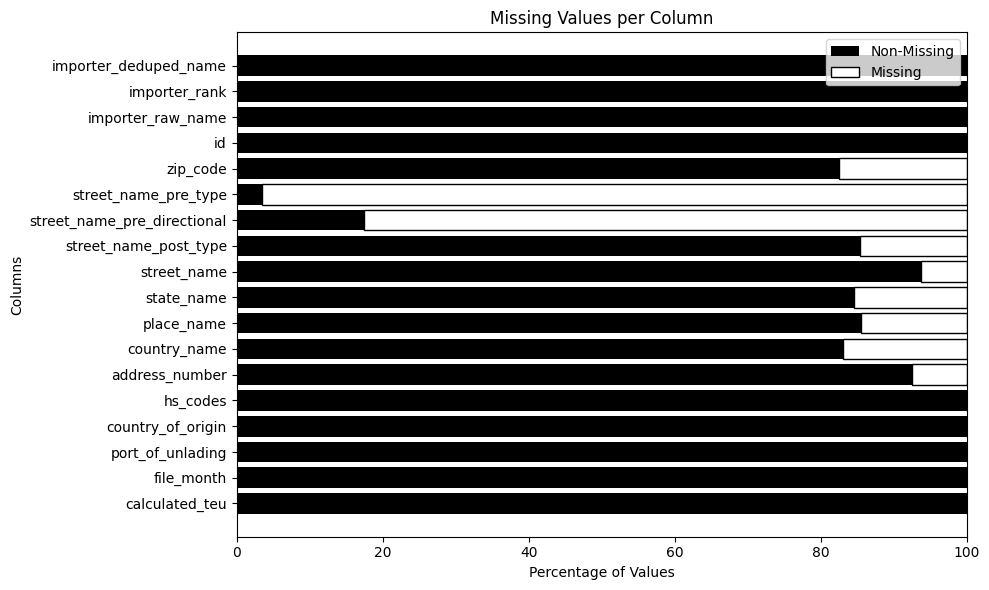

In [12]:
plot_missing_values(main.drop(["consignee", "extracted"],
                              axis=1),
                    as_percentage=True
                   )

### Observation 1: missing counts
`street_name_pre_type` and `street_name_pre_directional` have very high missing counts (approx 96% and 80% respectively)

### Observation 2: Imperfection of the cleaning method [OPTIONAL]

`cleaned_address_breakdown` seems to be a result by another extraction procedure.
This extraction is not perfect, as shown  in the graph of top 10 countries by frequencies in `main.csv`: sometimes it excludes STATES from UNITED STATES, yielding UNITED (which is a mistake)

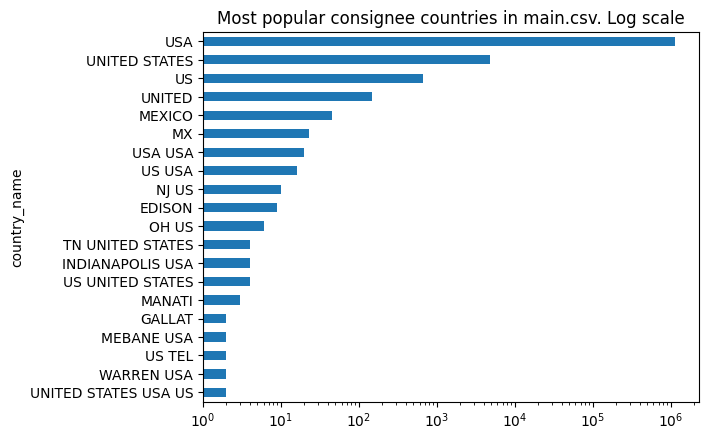

In [13]:
fig, ax = plt.subplots()
main['country_name'].value_counts().head(20)[::-1].plot.barh(log=True, ax=ax);
ax.set_title("Most popular consignee countries in main.csv. Log scale")
plt.show()

In [14]:
pprint("An example where UNITED STATES became UNITED after *cleaned*:")
pprint(main[main['country_name']=='UNITED']['consignee'].iloc[9])

An example where UNITED STATES became UNITED after *cleaned*:

{name=DAVID PEYSER SPORTSWEAR INC., address=90 SPENCE STREET, BAYSHORE, N.Y.11706, UNITED STATES., cleaned_address=90 SPENCE STREET, UNITED, cleaned_address_breakdown={address_number=90, country_name=UNITED, place_name=, state_name=, street_name=SPENCE, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=}, contact_name=, comm_number_qualifier=, comm_number=, id=9172da5f709b1914663d3b0e68f0243f}

In addition, sometimes the state name or another territory name gets in the `country_name`: NY in NY USA for instance.

Finally, synonyms were not handled at all: UNITED STATES, USA, US, USA US are the same thing.

Imperfection of the extraction on the country name level is a strong reason to assume the same happening in lower levels.

**How to fix that?** Use a better extraction method, such as Named Entity Recognition. For instance:

#### Demo Named-Entity-Recognition [OPTIONAL]

In [15]:
nlp = get_model() # Retrieve a prepared example NER model for country name detection

# Get some example consignee strings
samples_others = list(main[main['country_name']
                           .str
                           .lower()
                           .str.contains('serbia|taiwan') == True
                          ]['consignee'])[:2]
samples_us = list(main[main['country_name'].str.lower().str.contains('usa|united state| us') == True]['consignee'])[:1]

pprint("Showing an alternative way to extract country name:")
for example in samples_others + samples_us:
    displacy.render(
        nlp(example),
        style='ent')
    print("="*20)

Showing an alternative way to extract country name:

In the example above, my model is able to detect both US and UNITED STATES as the synonyms for USA.

Since developing such as model requires gathering  more country names and synonyms, I only show an example for a small number of countries as above.

### Observation 3: duplicated rows

Many rows in `main.csv` are exactly the same. **Possible reasons:**
- someone made a join with another duplicated dataframe ealier, resulting in duplicates in `main.csv`
- there's a missing column, which can be a key by itself or part of a composite key.

**Assuming this duplication is an error** (likely caused by join with duplicated data), I drop the duplicates:

In [16]:
before = main.shape[0]
pprint(f"`main.csv`: Number of rows before = {before}")

main = (main
        .drop_duplicates(subset=original_columns)
        .reset_index(drop=True)
       )

pprint(f"`main.csv`: Number of rows after drop_duplicates = {main.shape[0]}")
pprint(f"Drop rate = {round(100*(1- main.shape[0]/before))}%")

`main.csv`: Number of rows before = 1385308

`main.csv`: Number of rows after drop_duplicates = 531578

Drop rate = 62%

### Observation 4: one de-duplicated name is mapped to multiple id

In [17]:
main.groupby('importer_deduped_name')['id'].agg('nunique').sort_values(ascending=False).head(20)

importer_deduped_name
SOUTHERN GLAZERS WINE & SPIRITS       110
IKEA                                   53
LG ELECTRONICS                         48
SPECTRUM BRANDS HOLDINGS INC           39
COSMOS GRANITE & MARBLE LLC            38
THE PROCTER & GAMBLE COMPANY           37
WELLS FARGO & COMPANY                  35
GILDAN ACTIVEWEAR INC                  31
SAMSUNG ELECTRONICS AMERICA INC        31
DEERE & COMPANY                        31
ELECTROLUX AB                          30
THE GOODYEAR TIRE & RUBBER COMPANY     30
ROBERT BOSCH GMBH                      29
JPMORGAN CHASE & CO                    29
CONTINENTAL TIRE THE AMERICAS LLC      29
SCHNEIDER ELECTRIC SE                  27
NISSAN MOTOR COMPANY LTD               27
PANASONIC CORP                         25
GOYA FOODS INC                         24
MICHELIN NORTH AMERICA INC             24
Name: id, dtype: int64

It shows that each importer might be associated with multiple consignee id.

Not sure what's the id is for, but at this step I will assume that it's not the importer's.

For the rest of this notebook, I will use the importer deduped name as importer's identification

### HS codes mapping

In this subsection, I convert the first 4 digits in HS codes to their description (Chapter and Heading)

I do this to achieve a medium level of granularity for analysis and ML later

Implementation details:

- I used an opensource database [here](https://github.com/datasets/harmonized-system/tree/master) to lookup the hs codes
- To speed-up, I search for **unique hs codes** before mapping, rather than mapping straight away

In [18]:
hs_table = pd.read_csv('https://raw.githubusercontent.com/datasets/harmonized-system/master/data/harmonized-system.csv', dtype='str')

main['hs_codes_shorten'] = main['hs_codes'].str.replace(r'(\D)', '', regex=True).apply(lambda x: x[:4])

main['hs_codes_chapter'] = main['hs_codes'].str.replace(r'(\D)', '', regex=True).apply(lambda x: x[:2])


def query_hs_codes_desc(code, table):
    result = table.query("hscode==@code")['description']
    if result.shape[0] == 0:
        return None
    else:
        return list(result)[0]

hs_mapping = main[['hs_codes_shorten']].drop_duplicates().reset_index(drop=True)
hs_mapping['desc'] = hs_mapping['hs_codes_shorten'].apply(
    lambda x: query_hs_codes_desc(x, hs_table)
)

hs_mapping = hs_mapping.set_index('hs_codes_shorten')['desc']
hs_mapping = hs_mapping.to_dict()
main['hs_codes_desc'] = main['hs_codes_shorten'].apply(lambda x: hs_mapping[x])

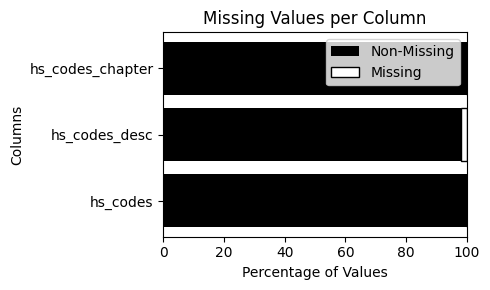

In [19]:
plot_missing_values(main[['hs_codes', "hs_codes_desc", "hs_codes_chapter"]], as_percentage=True, figsize=(5,3))

In [20]:
unk = main[main['hs_codes_desc'].isna()]
pprint(f"Number of `hs_codes` values whose description cannot be found = {unk.shape[0]} ~ {round(unk.shape[0]/main.shape[0] * 100, 2)}%")
pprint("Examples and their frequencies")
display(unk['hs_codes'].value_counts().head())
del(unk)

Number of `hs_codes` values whose description cannot be found = 9775 ~ 1.84%

Examples and their frequencies

hs_codes
HS CODE 0000 0000    140
HS CODE 2167 0000    116
HS CODE 8803 3000    100
HS CODE 1000 0000     96
HS CODE 6011 0000     71
Name: count, dtype: int64

# Only cares about row in main that can map to ports



In [21]:
copy = main[main['port_of_unlading'].isin(set(ports['port_code']))]
print(f"Before dropping rows with unknown ports: rows = {main.shape[0]}")
print(f"After dropping rows with unknown ports:  rows = {copy.shape[0]}")

Before dropping rows with unknown ports: rows = 531578
After dropping rows with unknown ports:  rows = 531578


No row is dropped (which is good)

In [22]:
# Saving datasets
main[['id', 'importer_deduped_name', 'importer_rank', 'zip_code', 'state_name',
      'hs_codes_shorten', 'hs_codes_desc', 'hs_codes_chapter',
      'country_of_origin', 'port_of_unlading', 'file_month', 
      'calculated_teu']].to_parquet("../datasets/main.parquet")

main[["importer_deduped_name", "importer_rank"]].drop_duplicates().to_parquet("../datasets/importers.parquet")

ports.drop_duplicates().to_parquet("../datasets/ports.parquet")

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


# Analytics plan

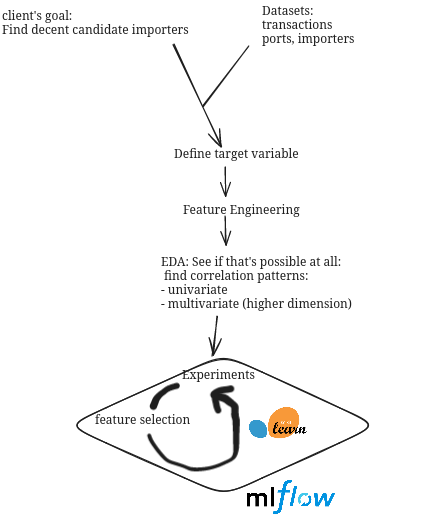

## Goal assumption

Assume that Blume is sensitive to risks, the metrics to be optimized for such a model should be precision for high class.

In other words, everytime we predict that an importer belongs to a high class, we want to be as certain as we can. We place less importance on recall mistakes (made when we mis-classified a high-class as lower)

## Importer class

Based on the distribution of ranks, I decide to:

- Consider all ranks above 5000 as lowest class
- Next lowest class is 2000~5000
- Best class is top 500

In [24]:
# Reload the cleaned datasets
main = dl.load('main_cleaned')
ports = dl.load('ports_cleaned')
importers = dl.load('importers_cleaned')


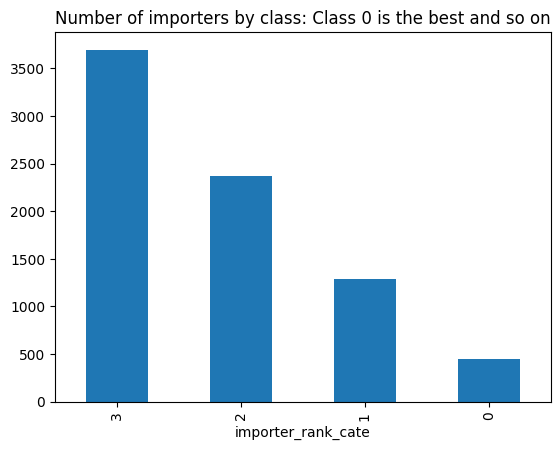

In [25]:
# Split the ranks into bins
importers['importer_rank_cate'] = importers['importer_rank'].apply(lambda x : 0 if x < 500
                                                                   else (1 if x < 2000 
                                                                         else (2 if x < 5000 else 3)
                                                                        )
                                                                  )

importers['importer_rank_cate'].value_counts().plot.bar();
plt.title("Number of importers by class: Class 0 is the best and so on");

## importer attributes

`n_states`: The number of unique states associated with each importer ID (in consignee string).

`n_zipcodes`: The number of unique zipcodes associated with each importer ID (in consignee string).

`n_months`: The number of unique filing months for each importer ID.

`n_origins`: The number of unique countries of origin for each importer ID.

`total_teu`: The sum of calculated TEU (twenty-foot equivalent units) across all records for each importer ID.

`avg_teu`: The average of calculated TEU (twenty-foot equivalent units) across all records for each importer ID.

`n_goods`: The number of unique HS codes (Harmonized System codes) across all records for each importer ID.

`n_ports`: The number of unique ports of unlading across all records for each importer ID.

`n_states`: The number of unique states of unlading across all records for each importer ID.

`major_origin`: The country of origin that appears most frequently for each importer ID.

`major_goods`: The HS code that appears most frequently for each importer ID.

`major_port_state`: The state of unlading that appears most frequently for each importer ID.

`biggest_gap`: The maximum time gap between consecutive filing months for each importer ID.

`smallest_gap`: The minimum time gap between consecutive filing months for each importer ID.

`mean_gap`: The mean time gap between consecutive filing months for each importer ID.

In [26]:
# inner join is ok here because we made sure now rows will be dropped in the cleaning step
main = main.merge(ports, left_on="port_of_unlading", right_on="port_code", how="inner")
main = main.merge(importers[['importer_deduped_name', 'importer_rank_cate']], how='inner')


# Calculating attributes

importer_profile = (
    main
    .sort_values(['importer_deduped_name', 'file_month'])
    .groupby('importer_deduped_name')
    .agg(
        n_zipcodes=('zip_code', 'nunique'),
        n_istates=('state_name', 'nunique'),
        importer_rank_cate=('importer_rank_cate', 'first'),
        importer_rank=('importer_rank', 'min'),
        n_months=('file_month', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        total_teu=('calculated_teu', 'sum'),
        avg_teu=('calculated_teu', 'mean'),
        n_goods=('hs_codes_shorten', 'nunique'),
        n_chapters=('hs_codes_chapter', 'nunique'),
        n_ports=('port_of_unlading', 'nunique'),
        n_states=('port_state', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
        major_goods=('hs_codes_shorten', lambda x: x.value_counts().idxmax()),
        major_port_state=('port_state', lambda x: x.value_counts().idxmax()),
        biggest_gap=('file_month', lambda x: x.drop_duplicates().diff().max()),
        smallest_gap=('file_month', lambda x: x.drop_duplicates().diff().min()),
    )
)

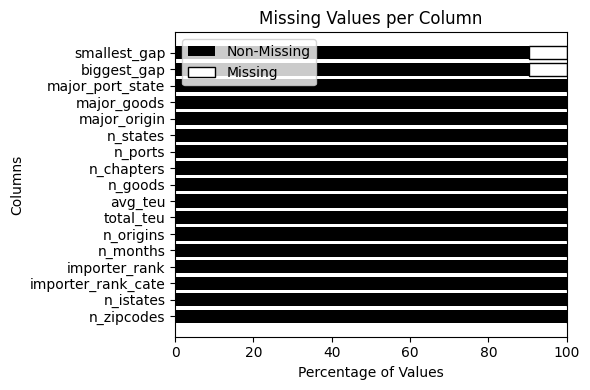

In [27]:
plot_missing_values(importer_profile,
                    as_percentage=True,
                    figsize=(6,4)
                   )

It shows that we have missing values for gap attributes caused by no gaps exist at all (companies that only import in ONE month), which is a curious case. 

## EDA for correlation patterns

Upon examination of these cases (active in only one month), I find some patterns that correlate with ranking. For instance:

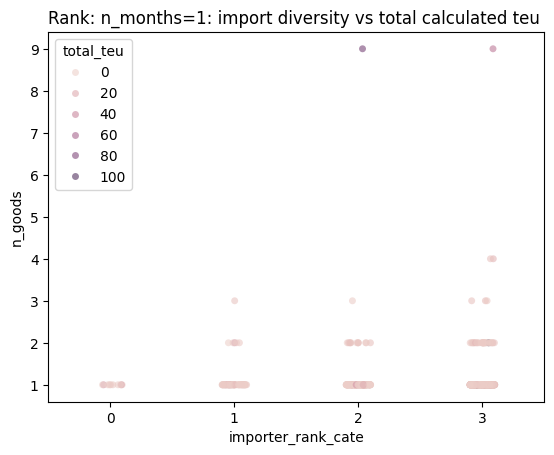

In [31]:
sns.stripplot(data=importer_profile[importer_profile['biggest_gap'].isna()],
               x="importer_rank_cate", y="n_goods", hue='total_teu', alpha=.6);
plt.title("Rank: n_months=1: import diversity vs total calculated teu ");

It shows that importer rank might relates to the portfolio size for cases where importer was active in only 1 month: `n_goods` is tighter in higher classes

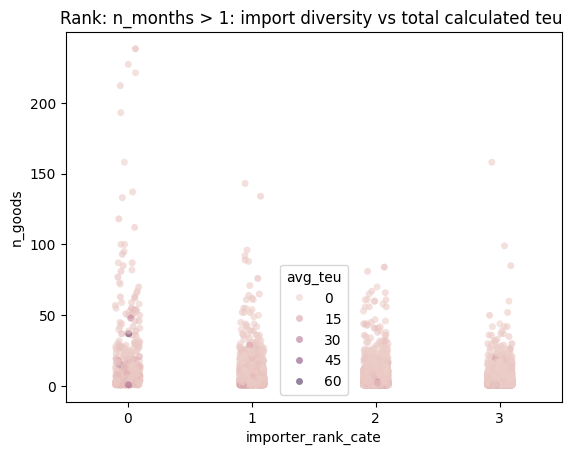

In [43]:
sns.stripplot(data=importer_profile[~importer_profile['biggest_gap'].isna()],
               x="importer_rank_cate", y="n_goods", hue='avg_teu', alpha=.6);
plt.title("Rank: n_months > 1: import diversity vs total calculated teu ");

The plot above shows that, the same pattern is not as clear when n_months > 1, if not slightly revesersed.

This leads to 2 probabilities :
- the dependencies if exists might be found in a higher dimensional space (something that correlation plots cannot pick up but tree models might)
- categorical values might be also important indicators of rank.

Before moving on, I will fill the nans with 12 (the number of months). This is to assume that the importer only purchase one per year (which is reasonable given the data)

In [44]:
gap_cols = ['smallest_gap', 'biggest_gap']
for col in gap_cols:
    importer_profile[col] = importer_profile[col].fillna(12)

# tsne

As mentioned above, we wan to know if numerical dependency happens in higher dimensions

To confirm that, we use TSNE to reduce the data to 2 dimensions and check for clustering. TSNE is known for the ability to make datapoints closer, which align with our goal: to identify the cluster of high-class importers

In [46]:
numericals = ["n_months", "n_origins", "total_teu",
             "avg_teu", "n_goods", "n_chapters", "n_ports", "n_states",
             "biggest_gap", "smallest_gap", "n_zipcodes", "n_istates"]

categoricals = ["major_origin", "major_goods", "major_port_state"]

target = 'importer_rank_cate'

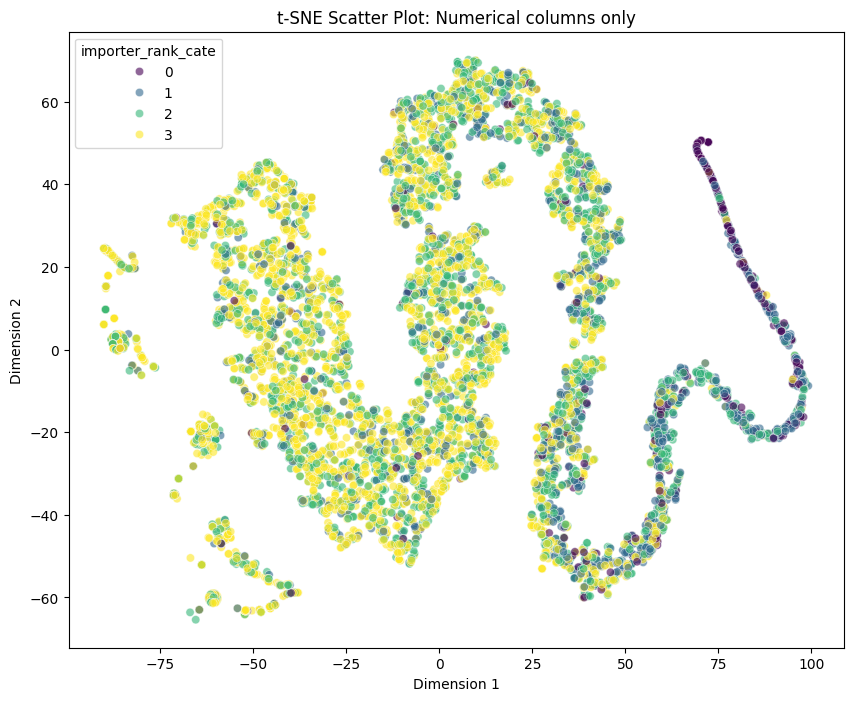

In [49]:
# Get dummies for categorical columns
df_dummies = pd.get_dummies(importer_profile[categoricals])

# Concatenate the numeric columns and dummy variables
df_processed = pd.concat([importer_profile[numericals], df_dummies], axis=1)


tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_processed[numericals])

# Create a DataFrame with the reduced dimensions
df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Add the 'importer_rank_cate' column to the reduced DataFrame
df_tsne[target] = list(importer_profile[target])

# Step 3: Scatter plot using the reduced dimensions
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2',
                hue=target,
                data=df_tsne,
                palette='viridis',
               alpha=.6)
plt.title("t-SNE Scatter Plot: Numerical columns only")
plt.show()


We can see from the plot above that there is actually a cluster that looks like a long whipping tail on the right of the graph where high-class importers locate. 

The clustering is not as clear for other charted areas, where both high and low classes mingle.

Having said that, this is still a significant finding. \
It suggests that we can train a model to just look at certain section of the data and assign a high class, achieving high precision. From the investment perspective, these are the low risk zone.

The pattern is not as clear when in comes to categorical values

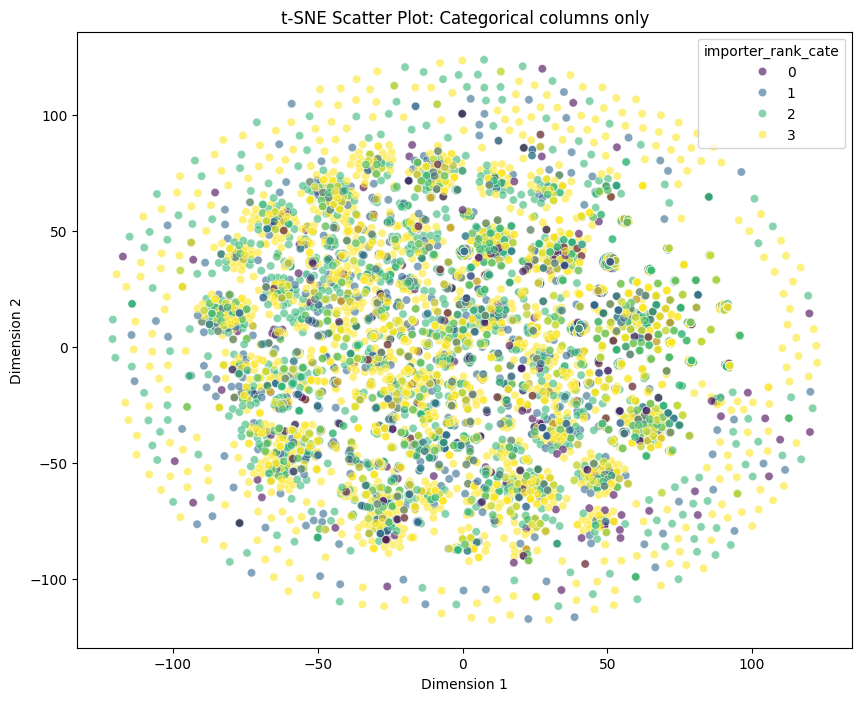

In [48]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_processed[[i for i in df_processed.columns if i not in numericals]])

# Create a DataFrame with the reduced dimensions
df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Add the 'importer_rank_cate' column to the reduced DataFrame
df_tsne[target] = list(importer_profile[target])

# Step 3: Scatter plot using the reduced dimensions
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2',
                hue=target,
                data=df_tsne,
                palette='viridis',
               alpha=.6)
plt.title("t-SNE Scatter Plot: Categorical columns only")
plt.show()


# Experiment setting

As concluded above, it is possible to create a low-risk classification model

Experiments:

split: 80-20 (**stratified** by the target variable)


Features:

    - numerics only
    - all features
    
Classifier:

    - LogisticRegressor
    - DecisionTree
    - GradientBoosting
    - xgb
    
Optimizing metrics:

    - weighted precision_score

Optimization: 
    
    - automatically using hyperopt
    
Tracking method:

    - mlflow

In [50]:
# Save the datafile for next ML tasks
importer_profile.to_parquet("../datasets/ml_datasets.parquet")

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [55]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("importer-class-experiment")


2023/11/23 10:31:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/11/23 10:31:25 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/tunglinux/units/python_practice/impgenius/notebooks/mlruns/1', creation_time=1700710285871, experiment_id='1', last_update_time=1700710285871, lifecycle_stage='active', name='importer-class-experiment', tags={}>

In [53]:
numericals = ["n_months", "n_origins", "total_teu",
             "avg_teu", "n_goods", "n_chapters", "n_ports",
              "n_states", "biggest_gap", "smallest_gap",
              "n_zipcodes", "n_istates"]

categoricals = ["major_origin", "major_goods", "major_port_state"]

target = 'importer_rank_cate'

df = DataLoader("../catalog.yml").load('ml_dataset')
pprint(f"Retrieved dataset: {df.shape}")


Retrieved dataset: (7747, 17)

In [54]:
# Split data into train and validation sets (80-20, stratified)
def split_data(X, y):
    X_train, X_val, y_train, y_val = train_test_split(
        X, 
        y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    return X_train, X_val, y_train, y_val


# Objective function decorator
def objective(func):
    @wraps(func)
    def wrapper(params):
        
        with mlflow.start_run():
            y_val_pred = func(params)
            # Calculate precision
            precision = precision_score(y_val, y_val_pred, average='weighted')

        return {'loss': 1 - precision, 'status': STATUS_OK}



    return wrapper

# Define the objective function for Gradient Boosting

@objective
def gradient_boosting_objective(params):
    
    mlflow.set_tag("model", "gb")
    mlflow.log_params(params)

    # Initialize and train the Gradient Boosting classifier
    clf = GradientBoostingClassifier(**params, random_state=0)
    clf.fit(X_train, y_train)
    
    return clf.predict(X_val)        


# Define the objective function for XGBoost


@objective
def xgb_objective(params):
    
    mlflow.set_tag("model", "xgb")
    mlflow.log_params(params)
    
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50
    )

    return booster.predict(dval)        

@objective
def lr_objective(params):
    mlflow.set_tag("model", "lr")
    mlflow.log_params(params)

    # Initialize and train the Softmax (Logistic Regression) classifier
    lr = LogisticRegression(
        multi_class='multinomial',
        **params
    )
    lr.fit(X_train, y_train)

    return lr.predict(X_val)

@objective
def dt_objective(params):
    mlflow.set_tag("model", "dt")
    mlflow.log_params(params)

    # Initialize and train the Decision Tree classifier
    clf = DecisionTreeClassifier(**params, random_state=0)
    clf.fit(X_train, y_train)

    return clf.predict(X_val)


# Define hyperparameter space for hyperopt
xgb_space = {
    'objective': 'multi:softmax',
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.5, .9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'num_class': 4
    }

gb_space = {
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 2, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 30, 1)),
    }

# Define hyperparameter space for hyperopt
lr_space = {
    'n_jobs': -1,
    'penalty': "l2",
    'max_iter': int(1e8)
}


# Define the search space for Decision Tree
dt_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': scope.int(hp.uniform('max_depth', 7, 15)),
    'min_samples_split': hp.loguniform('min_samples_split', -4, -1),
    'class_weight': 'balanced'
    }

## Numerical features only

In [57]:
X = df[numericals]
y = df[target]


X_train, X_val, y_train, y_val = split_data(X, y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

y_train = y_train.ravel()
y_val = y_val.ravel()

In [58]:
%%time
# Model 1: xgb
xgb_best_result = fmin(
    fn=xgb_objective,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)




[0]	validation-mlogloss:1.36001                                                  
[1]	validation-mlogloss:1.33741                                                  
[2]	validation-mlogloss:1.31579                                                  
[3]	validation-mlogloss:1.29716                                                  
[4]	validation-mlogloss:1.28009                                                  
[5]	validation-mlogloss:1.26237                                                  
[6]	validation-mlogloss:1.24633                                                  
[7]	validation-mlogloss:1.23199                                                  
[8]	validation-mlogloss:1.21817                                                  
[9]	validation-mlogloss:1.20515                                                  
[10]	validation-mlogloss:1.19329                                                 
[11]	validation-mlogloss:1.18281                                                 
[12]	validation-

[98]	validation-mlogloss:1.00899                                                 
[99]	validation-mlogloss:1.00929                                                 
[0]	validation-mlogloss:1.32513                                                  
[1]	validation-mlogloss:1.27960                                                  
[2]	validation-mlogloss:1.24378                                                  
[3]	validation-mlogloss:1.21322                                                  
[4]	validation-mlogloss:1.18844                                                  
[5]	validation-mlogloss:1.16372                                                  
[6]	validation-mlogloss:1.14556                                                  
[7]	validation-mlogloss:1.12966                                                  
[8]	validation-mlogloss:1.11409                                                  
[9]	validation-mlogloss:1.10128                                                  
[10]	validation-

[0]	validation-mlogloss:1.35436                                                  
[1]	validation-mlogloss:1.32702                                                  
[2]	validation-mlogloss:1.30261                                                  
[3]	validation-mlogloss:1.28067                                                  
[4]	validation-mlogloss:1.26029                                                  
[5]	validation-mlogloss:1.24104                                                  
[6]	validation-mlogloss:1.22418                                                  
[7]	validation-mlogloss:1.20898                                                  
[8]	validation-mlogloss:1.19434                                                  
[9]	validation-mlogloss:1.18084                                                  
[10]	validation-mlogloss:1.16889                                                 
[11]	validation-mlogloss:1.15772                                                 
[12]	validation-

[30]	validation-mlogloss:1.02065                                                 
[31]	validation-mlogloss:1.02064                                                 
[32]	validation-mlogloss:1.01930                                                 
[33]	validation-mlogloss:1.01977                                                 
[34]	validation-mlogloss:1.01967                                                 
[35]	validation-mlogloss:1.01956                                                 
[36]	validation-mlogloss:1.01928                                                 
[37]	validation-mlogloss:1.01825                                                 
[38]	validation-mlogloss:1.01846                                                 
[39]	validation-mlogloss:1.01956                                                 
[40]	validation-mlogloss:1.01900                                                 
[41]	validation-mlogloss:1.02094                                                 
[42]	validation-

[68]	validation-mlogloss:1.01753                                                 
[69]	validation-mlogloss:1.01713                                                 
[70]	validation-mlogloss:1.01690                                                 
[71]	validation-mlogloss:1.01634                                                 
[72]	validation-mlogloss:1.01599                                                 
[73]	validation-mlogloss:1.01549                                                 
[74]	validation-mlogloss:1.01505                                                 
[75]	validation-mlogloss:1.01476                                                 
[76]	validation-mlogloss:1.01459                                                 
[77]	validation-mlogloss:1.01417                                                 
[78]	validation-mlogloss:1.01398                                                 
[79]	validation-mlogloss:1.01373                                                 
[80]	validation-

[66]	validation-mlogloss:1.01327                                                 
[67]	validation-mlogloss:1.01311                                                 
[68]	validation-mlogloss:1.01291                                                 
[69]	validation-mlogloss:1.01263                                                 
[70]	validation-mlogloss:1.01232                                                 
[71]	validation-mlogloss:1.01189                                                 
[72]	validation-mlogloss:1.01122                                                 
[73]	validation-mlogloss:1.01125                                                 
[74]	validation-mlogloss:1.01096                                                 
[75]	validation-mlogloss:1.01051                                                 
[76]	validation-mlogloss:1.01064                                                 
[77]	validation-mlogloss:1.01046                                                 
[78]	validation-

[64]	validation-mlogloss:1.01246                                                 
[65]	validation-mlogloss:1.01233                                                 
[66]	validation-mlogloss:1.01247                                                 
[67]	validation-mlogloss:1.01329                                                 
[68]	validation-mlogloss:1.01317                                                 
[69]	validation-mlogloss:1.01402                                                 
[70]	validation-mlogloss:1.01513                                                 
[71]	validation-mlogloss:1.01462                                                 
[72]	validation-mlogloss:1.01479                                                 
[73]	validation-mlogloss:1.01466                                                 
[74]	validation-mlogloss:1.01413                                                 
[75]	validation-mlogloss:1.01351                                                 
[76]	validation-

[67]	validation-mlogloss:1.02079                                                 
[68]	validation-mlogloss:1.02111                                                 
[69]	validation-mlogloss:1.02084                                                 
[70]	validation-mlogloss:1.02121                                                 
[71]	validation-mlogloss:1.02128                                                 
[72]	validation-mlogloss:1.02160                                                 
[73]	validation-mlogloss:1.02192                                                 
[74]	validation-mlogloss:1.02232                                                 
[75]	validation-mlogloss:1.02246                                                 
[76]	validation-mlogloss:1.02231                                                 
[77]	validation-mlogloss:1.02275                                                 
[78]	validation-mlogloss:1.02328                                                 
[79]	validation-

[9]	validation-mlogloss:1.21892                                                  
[10]	validation-mlogloss:1.20789                                                 
[11]	validation-mlogloss:1.19736                                                 
[12]	validation-mlogloss:1.18843                                                 
[13]	validation-mlogloss:1.17922                                                 
[14]	validation-mlogloss:1.17043                                                 
[15]	validation-mlogloss:1.16220                                                 
[16]	validation-mlogloss:1.15450                                                 
[17]	validation-mlogloss:1.14684                                                 
[18]	validation-mlogloss:1.13971                                                 
[19]	validation-mlogloss:1.13330                                                 
[20]	validation-mlogloss:1.12715                                                 
[21]	validation-

[7]	validation-mlogloss:1.04835                                                  
[8]	validation-mlogloss:1.03900                                                  
[9]	validation-mlogloss:1.03340                                                  
[10]	validation-mlogloss:1.02760                                                 
[11]	validation-mlogloss:1.02322                                                 
[12]	validation-mlogloss:1.02048                                                 
[13]	validation-mlogloss:1.01764                                                 
[14]	validation-mlogloss:1.01500                                                 
[15]	validation-mlogloss:1.01336                                                 
[16]	validation-mlogloss:1.01283                                                 
[17]	validation-mlogloss:1.01255                                                 
[18]	validation-mlogloss:1.01269                                                 
[19]	validation-

[34]	validation-mlogloss:1.09280                                                 
[35]	validation-mlogloss:1.08989                                                 
[36]	validation-mlogloss:1.08696                                                 
[37]	validation-mlogloss:1.08429                                                 
[38]	validation-mlogloss:1.08190                                                 
[39]	validation-mlogloss:1.07977                                                 
[40]	validation-mlogloss:1.07778                                                 
[41]	validation-mlogloss:1.07527                                                 
[42]	validation-mlogloss:1.07283                                                 
[43]	validation-mlogloss:1.07082                                                 
[44]	validation-mlogloss:1.06872                                                 
[45]	validation-mlogloss:1.06686                                                 
[46]	validation-

[32]	validation-mlogloss:1.03508                                                 
[33]	validation-mlogloss:1.03361                                                 
[34]	validation-mlogloss:1.03167                                                 
[35]	validation-mlogloss:1.03041                                                 
[36]	validation-mlogloss:1.02898                                                 
[37]	validation-mlogloss:1.02769                                                 
[38]	validation-mlogloss:1.02661                                                 
[39]	validation-mlogloss:1.02593                                                 
[40]	validation-mlogloss:1.02517                                                 
[41]	validation-mlogloss:1.02397                                                 
[42]	validation-mlogloss:1.02275                                                 
[43]	validation-mlogloss:1.02201                                                 
[44]	validation-

[30]	validation-mlogloss:1.03533                                                 
[31]	validation-mlogloss:1.03378                                                 
[32]	validation-mlogloss:1.03276                                                 
[33]	validation-mlogloss:1.03116                                                 
[34]	validation-mlogloss:1.02978                                                 
[35]	validation-mlogloss:1.02853                                                 
[36]	validation-mlogloss:1.02728                                                 
[37]	validation-mlogloss:1.02605                                                 
[38]	validation-mlogloss:1.02490                                                 
[39]	validation-mlogloss:1.02404                                                 
[40]	validation-mlogloss:1.02335                                                 
[41]	validation-mlogloss:1.02210                                                 
[42]	validation-

[28]	validation-mlogloss:1.03091                                                 
[29]	validation-mlogloss:1.02917                                                 
[30]	validation-mlogloss:1.02763                                                 
[31]	validation-mlogloss:1.02637                                                 
[32]	validation-mlogloss:1.02572                                                 
[33]	validation-mlogloss:1.02447                                                 
[34]	validation-mlogloss:1.02337                                                 
[35]	validation-mlogloss:1.02237                                                 
[36]	validation-mlogloss:1.02144                                                 
[37]	validation-mlogloss:1.02049                                                 
[38]	validation-mlogloss:1.01955                                                 
[39]	validation-mlogloss:1.01853                                                 
[40]	validation-

[26]	validation-mlogloss:1.01195                                                 
[27]	validation-mlogloss:1.01124                                                 
[28]	validation-mlogloss:1.01095                                                 
[29]	validation-mlogloss:1.01027                                                 
[30]	validation-mlogloss:1.00983                                                 
[31]	validation-mlogloss:1.00883                                                 
[32]	validation-mlogloss:1.00912                                                 
[33]	validation-mlogloss:1.00934                                                 
[34]	validation-mlogloss:1.00851                                                 
[35]	validation-mlogloss:1.00784                                                 
[36]	validation-mlogloss:1.00788                                                 
[37]	validation-mlogloss:1.00689                                                 
[38]	validation-

[47]	validation-mlogloss:1.00764                                                 
[48]	validation-mlogloss:1.00769                                                 
[49]	validation-mlogloss:1.00816                                                 
[50]	validation-mlogloss:1.00881                                                 
[51]	validation-mlogloss:1.00871                                                 
[52]	validation-mlogloss:1.00856                                                 
[53]	validation-mlogloss:1.00888                                                 
[54]	validation-mlogloss:1.00899                                                 
[55]	validation-mlogloss:1.00900                                                 
[56]	validation-mlogloss:1.00871                                                 
[57]	validation-mlogloss:1.00902                                                 
[58]	validation-mlogloss:1.00879                                                 
[59]	validation-

[62]	validation-mlogloss:1.00549                                                 
[63]	validation-mlogloss:1.00553                                                 
[64]	validation-mlogloss:1.00534                                                 
[65]	validation-mlogloss:1.00517                                                 
[66]	validation-mlogloss:1.00535                                                 
[67]	validation-mlogloss:1.00536                                                 
[68]	validation-mlogloss:1.00533                                                 
[69]	validation-mlogloss:1.00514                                                 
[70]	validation-mlogloss:1.00536                                                 
[71]	validation-mlogloss:1.00519                                                 
[72]	validation-mlogloss:1.00474                                                 
[73]	validation-mlogloss:1.00481                                                 
[74]	validation-

[64]	validation-mlogloss:1.01411                                                 
[65]	validation-mlogloss:1.01351                                                 
[66]	validation-mlogloss:1.01306                                                 
[67]	validation-mlogloss:1.01268                                                 
[68]	validation-mlogloss:1.01259                                                 
[69]	validation-mlogloss:1.01236                                                 
[70]	validation-mlogloss:1.01212                                                 
[71]	validation-mlogloss:1.01180                                                 
[72]	validation-mlogloss:1.01117                                                 
[73]	validation-mlogloss:1.01099                                                 
[74]	validation-mlogloss:1.01046                                                 
[75]	validation-mlogloss:1.01004                                                 
[76]	validation-

[62]	validation-mlogloss:1.00522                                                 
[63]	validation-mlogloss:1.00519                                                 
[64]	validation-mlogloss:1.00523                                                 
[65]	validation-mlogloss:1.00486                                                 
[66]	validation-mlogloss:1.00478                                                 
[67]	validation-mlogloss:1.00517                                                 
[68]	validation-mlogloss:1.00511                                                 
[69]	validation-mlogloss:1.00549                                                 
[70]	validation-mlogloss:1.00599                                                 
[71]	validation-mlogloss:1.00568                                                 
[72]	validation-mlogloss:1.00534                                                 
[73]	validation-mlogloss:1.00517                                                 
[74]	validation-

[60]	validation-mlogloss:1.00671                                                 
[61]	validation-mlogloss:1.00682                                                 
[62]	validation-mlogloss:1.00638                                                 
[63]	validation-mlogloss:1.00650                                                 
[64]	validation-mlogloss:1.00641                                                 
[65]	validation-mlogloss:1.00589                                                 
[66]	validation-mlogloss:1.00576                                                 
[67]	validation-mlogloss:1.00568                                                 
[68]	validation-mlogloss:1.00556                                                 
[69]	validation-mlogloss:1.00543                                                 
[70]	validation-mlogloss:1.00543                                                 
[71]	validation-mlogloss:1.00556                                                 
[72]	validation-

[65]	validation-mlogloss:1.01905                                                 
[66]	validation-mlogloss:1.01874                                                 
[67]	validation-mlogloss:1.01850                                                 
[68]	validation-mlogloss:1.01809                                                 
[69]	validation-mlogloss:1.01783                                                 
[70]	validation-mlogloss:1.01738                                                 
[71]	validation-mlogloss:1.01696                                                 
[72]	validation-mlogloss:1.01651                                                 
[73]	validation-mlogloss:1.01612                                                 
[74]	validation-mlogloss:1.01571                                                 
[75]	validation-mlogloss:1.01520                                                 
[76]	validation-mlogloss:1.01502                                                 
[77]	validation-

[63]	validation-mlogloss:1.02516                                                 
[64]	validation-mlogloss:1.02462                                                 
[65]	validation-mlogloss:1.02390                                                 
[66]	validation-mlogloss:1.02343                                                 
[67]	validation-mlogloss:1.02285                                                 
[68]	validation-mlogloss:1.02251                                                 
[69]	validation-mlogloss:1.02197                                                 
[70]	validation-mlogloss:1.02157                                                 
[71]	validation-mlogloss:1.02110                                                 
[72]	validation-mlogloss:1.02075                                                 
[73]	validation-mlogloss:1.02030                                                 
[74]	validation-mlogloss:1.01995                                                 
[75]	validation-

[61]	validation-mlogloss:1.00673                                                 
[62]	validation-mlogloss:1.00662                                                 
[63]	validation-mlogloss:1.00715                                                 
[64]	validation-mlogloss:1.00684                                                 
[65]	validation-mlogloss:1.00706                                                 
[66]	validation-mlogloss:1.00702                                                 
[67]	validation-mlogloss:1.00724                                                 
[68]	validation-mlogloss:1.00722                                                 
[69]	validation-mlogloss:1.00732                                                 
[70]	validation-mlogloss:1.00722                                                 
[71]	validation-mlogloss:1.00724                                                 
[72]	validation-mlogloss:1.00719                                                 
[73]	validation-

[64]	validation-mlogloss:1.00924                                                 
[65]	validation-mlogloss:1.00896                                                 
[66]	validation-mlogloss:1.00900                                                 
[67]	validation-mlogloss:1.00914                                                 
[68]	validation-mlogloss:1.00920                                                 
[69]	validation-mlogloss:1.00916                                                 
[70]	validation-mlogloss:1.00905                                                 
[71]	validation-mlogloss:1.00883                                                 
[72]	validation-mlogloss:1.00875                                                 
[73]	validation-mlogloss:1.00883                                                 
[74]	validation-mlogloss:1.00887                                                 
[75]	validation-mlogloss:1.00883                                                 
[76]	validation-

[66]	validation-mlogloss:1.01968                                                 
[67]	validation-mlogloss:1.02075                                                 
[68]	validation-mlogloss:1.02098                                                 
[69]	validation-mlogloss:1.02172                                                 
[70]	validation-mlogloss:1.02267                                                 
[71]	validation-mlogloss:1.02240                                                 
[72]	validation-mlogloss:1.02162                                                 
[73]	validation-mlogloss:1.02219                                                 
[74]	validation-mlogloss:1.02170                                                 
[75]	validation-mlogloss:1.02227                                                 
100%|█████████| 50/50 [01:56<00:00,  2.33s/trial, best loss: 0.44996429015434924]
CPU times: user 4min 41s, sys: 5.35 s, total: 4min 46s
Wall time: 1min 56s


In [63]:
xgb_best = xgb.train(
    params=hyperopt.space_eval(xgb_space, xgb_best_result),
    dtrain=dtrain, 
    num_boost_round=100,
    evals=[(dval, 'validation')])

y_val_pred_xgb = xgb_best.predict(dval).astype(int)
xgb_report = classification_report(y_val, y_val_pred_xgb)

print(xgb_report)

[0]	validation-mlogloss:1.31466
[1]	validation-mlogloss:1.26402
[2]	validation-mlogloss:1.22286
[3]	validation-mlogloss:1.19073
[4]	validation-mlogloss:1.16501
[5]	validation-mlogloss:1.14035
[6]	validation-mlogloss:1.12160
[7]	validation-mlogloss:1.10719
[8]	validation-mlogloss:1.09362
[9]	validation-mlogloss:1.08295
[10]	validation-mlogloss:1.07333
[11]	validation-mlogloss:1.06530
[12]	validation-mlogloss:1.05906
[13]	validation-mlogloss:1.05260
[14]	validation-mlogloss:1.04723
[15]	validation-mlogloss:1.04363
[16]	validation-mlogloss:1.03977
[17]	validation-mlogloss:1.03613
[18]	validation-mlogloss:1.03244
[19]	validation-mlogloss:1.02944
[20]	validation-mlogloss:1.02758
[21]	validation-mlogloss:1.02554
[22]	validation-mlogloss:1.02390
[23]	validation-mlogloss:1.02181
[24]	validation-mlogloss:1.02042
[25]	validation-mlogloss:1.01930
[26]	validation-mlogloss:1.01801
[27]	validation-mlogloss:1.01679
[28]	validation-mlogloss:1.01610
[29]	validation-mlogloss:1.01509
[30]	validation-mlog

In [64]:
# Model 2: gb
gb_best_result = fmin(
    fn=gradient_boosting_objective,
    space=gb_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  6%|▌         | 3/50 [00:01<00:26,  1.80trial/s, best loss: 0.48082888130400514]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 10%|█         | 5/50 [00:02<00:24,  1.86trial/s, best loss: 0.46376899827317253]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 12%|█▏        | 6/50 [00:03<00:24,  1.79trial/s, best loss: 0.46376899827317253]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 18%|█▊        | 9/50 [00:05<00:25,  1.59trial/s, best loss: 0.46376899827317253]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 26%|██▎      | 13/50 [00:07<00:19,  1.91trial/s, best loss: 0.46376899827317253]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 92%|████████▎| 46/50 [00:28<00:02,  1.70trial/s, best loss: 0.45465191104840585]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|█████████| 50/50 [00:30<00:00,  1.65trial/s, best loss: 0.45345705550585635]


In [65]:
gb_best_params = hyperopt.space_eval(gb_space, gb_best_result)
gb_best = GradientBoostingClassifier(random_state=0, **gb_best_params)
gb_best.fit(X_train, y_train)
y_val_pred_gb = gb_best.predict(X_val).astype(int)
gb_report = classification_report(y_val, y_val_pred_gb)
print(gb_report)

              precision    recall  f1-score   support

           0       0.70      0.38      0.49        87
           1       0.54      0.29      0.38       255
           2       0.48      0.20      0.28       471
           3       0.57      0.91      0.70       737

    accuracy                           0.56      1550
   macro avg       0.57      0.45      0.46      1550
weighted avg       0.55      0.56      0.51      1550



In [66]:
# Model 3: lr
lr_best_result = fmin(
    fn=lr_objective,
    space=lr_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

100%|██████████| 50/50 [04:10<00:00,  5.02s/trial, best loss: 0.4713724402077746]


In [67]:
lr_best_params = hyperopt.space_eval(lr_space, lr_best_result)

lr_best = LogisticRegression(random_state=0, **lr_best_params)
lr_best.fit(X_train, y_train)

y_val_pred_lr = lr_best.predict(X_val).astype(int)
lr_report = classification_report(y_val, y_val_pred_lr)
print(lr_report)

              precision    recall  f1-score   support

           0       0.67      0.30      0.41        87
           1       0.52      0.23      0.32       255
           2       0.44      0.20      0.27       471
           3       0.57      0.92      0.70       737

    accuracy                           0.55      1550
   macro avg       0.55      0.41      0.43      1550
weighted avg       0.53      0.55      0.49      1550



In [68]:
# Model 4: dt
dt_best_result = fmin(
    fn=dt_objective,
    space=dt_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  8%|▉          | 4/50 [00:00<00:03, 13.81trial/s, best loss: 0.5554179792674347]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 32%|███▏      | 16/50 [00:01<00:02, 13.23trial/s, best loss: 0.5382091003733763]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [00:03<00:00, 12.92trial/s, best loss: 0.5359748599543784]


In [69]:
dt_best_params = hyperopt.space_eval(dt_space, dt_best_result)

# Train the final model with the best hyperparameters
dt_best = DecisionTreeClassifier(random_state=0, **dt_best_params)
dt_best.fit(X_train, y_train)

# Predict on the validation set with the best model
y_val_pred_dt = dt_best.predict(X_val).astype(int)

# Generate the classification report
dt_report = classification_report(y_val, y_val_pred_dt)
print(dt_report)

              precision    recall  f1-score   support

           0       0.24      0.64      0.35        87
           1       0.28      0.11      0.16       255
           2       0.36      0.38      0.37       471
           3       0.62      0.60      0.61       737

    accuracy                           0.46      1550
   macro avg       0.38      0.44      0.37      1550
weighted avg       0.46      0.46      0.45      1550



Since we focus on precision on higher classes (0 and 1), DT and LR underperform. 

Boosted models do much better with >= 70% precision. Recall is low but not too low (depends on your expectation)

## With categorical features

Keep in mind that when we introduce more features, we run the risk of overfitting.

This notebook is just to give a prototype


In [70]:
# OneHot encoding
X = pd.get_dummies(
    df.drop([target, 'importer_rank'], axis=1),
    columns=categoricals
)
y = df[target]

X_train, X_val, y_train, y_val = split_data(X, y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

y_train = y_train.ravel()
y_val = y_val.ravel()

In [71]:
# Model 1: xgb
xgb_best_result = fmin(
    fn=xgb_objective,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


[0]	validation-mlogloss:1.26891                                                  
[1]	validation-mlogloss:1.20055                                                  
[2]	validation-mlogloss:1.15257                                                  
[3]	validation-mlogloss:1.11678                                                  
[4]	validation-mlogloss:1.09215                                                  
[5]	validation-mlogloss:1.07450                                                  
[6]	validation-mlogloss:1.06222                                                  
[7]	validation-mlogloss:1.05124                                                  
[8]	validation-mlogloss:1.04267                                                  
[9]	validation-mlogloss:1.03640                                                  
[10]	validation-mlogloss:1.03128                                                 
[11]	validation-mlogloss:1.02700                                                 
[12]	validation-

[5]	validation-mlogloss:1.06320                                                  
[6]	validation-mlogloss:1.04930                                                  
[7]	validation-mlogloss:1.03850                                                  
[8]	validation-mlogloss:1.03070                                                  
[9]	validation-mlogloss:1.02554                                                  
[10]	validation-mlogloss:1.02182                                                 
[11]	validation-mlogloss:1.01762                                                 
[12]	validation-mlogloss:1.01503                                                 
[13]	validation-mlogloss:1.01337                                                 
[14]	validation-mlogloss:1.01162                                                 
[15]	validation-mlogloss:1.01058                                                 
[16]	validation-mlogloss:1.01072                                                 
[17]	validation-

[35]	validation-mlogloss:1.00840                                                 
[36]	validation-mlogloss:1.00887                                                 
[37]	validation-mlogloss:1.00845                                                 
[38]	validation-mlogloss:1.00820                                                 
[39]	validation-mlogloss:1.00805                                                 
[40]	validation-mlogloss:1.00868                                                 
[41]	validation-mlogloss:1.00944                                                 
[42]	validation-mlogloss:1.00974                                                 
[43]	validation-mlogloss:1.00978                                                 
[44]	validation-mlogloss:1.01088                                                 
[45]	validation-mlogloss:1.01006                                                 
[46]	validation-mlogloss:1.01033                                                 
[47]	validation-

[57]	validation-mlogloss:1.01836                                                 
[58]	validation-mlogloss:1.01821                                                 
[59]	validation-mlogloss:1.01853                                                 
[60]	validation-mlogloss:1.01847                                                 
[61]	validation-mlogloss:1.01943                                                 
[62]	validation-mlogloss:1.01977                                                 
[63]	validation-mlogloss:1.02047                                                 
[64]	validation-mlogloss:1.02044                                                 
[65]	validation-mlogloss:1.02060                                                 
[66]	validation-mlogloss:1.02042                                                 
[67]	validation-mlogloss:1.02123                                                 
[68]	validation-mlogloss:1.02087                                                 
[69]	validation-

[76]	validation-mlogloss:1.00687                                                 
[77]	validation-mlogloss:1.00774                                                 
[78]	validation-mlogloss:1.00790                                                 
[79]	validation-mlogloss:1.00836                                                 
[80]	validation-mlogloss:1.00921                                                 
[81]	validation-mlogloss:1.00913                                                 
[82]	validation-mlogloss:1.01065                                                 
[83]	validation-mlogloss:1.01168                                                 
[84]	validation-mlogloss:1.01319                                                 
[85]	validation-mlogloss:1.01372                                                 
[86]	validation-mlogloss:1.01452                                                 
[87]	validation-mlogloss:1.01492                                                 
[88]	validation-

[83]	validation-mlogloss:1.01293                                                 
[84]	validation-mlogloss:1.01284                                                 
[85]	validation-mlogloss:1.01314                                                 
[86]	validation-mlogloss:1.01365                                                 
[87]	validation-mlogloss:1.01408                                                 
[88]	validation-mlogloss:1.01425                                                 
[89]	validation-mlogloss:1.01396                                                 
[90]	validation-mlogloss:1.01448                                                 
[91]	validation-mlogloss:1.01465                                                 
[92]	validation-mlogloss:1.01496                                                 
[93]	validation-mlogloss:1.01619                                                 
[94]	validation-mlogloss:1.01705                                                 
[95]	validation-

[3]	validation-mlogloss:1.30084                                                  
[4]	validation-mlogloss:1.28334                                                  
[5]	validation-mlogloss:1.26687                                                  
[6]	validation-mlogloss:1.25211                                                  
[7]	validation-mlogloss:1.23773                                                  
[8]	validation-mlogloss:1.22485                                                  
[9]	validation-mlogloss:1.21192                                                  
[10]	validation-mlogloss:1.20042                                                 
[11]	validation-mlogloss:1.18931                                                 
[12]	validation-mlogloss:1.17975                                                 
[13]	validation-mlogloss:1.17046                                                 
[14]	validation-mlogloss:1.16146                                                 
[15]	validation-

[1]	validation-mlogloss:1.27275                                                  
[2]	validation-mlogloss:1.23128                                                  
[3]	validation-mlogloss:1.19793                                                  
[4]	validation-mlogloss:1.17090                                                  
[5]	validation-mlogloss:1.14889                                                  
[6]	validation-mlogloss:1.12955                                                  
[7]	validation-mlogloss:1.11275                                                  
[8]	validation-mlogloss:1.09871                                                  
[9]	validation-mlogloss:1.08637                                                  
[10]	validation-mlogloss:1.07686                                                 
[11]	validation-mlogloss:1.06860                                                 
[12]	validation-mlogloss:1.06182                                                 
[13]	validation-

[99]	validation-mlogloss:1.00559                                                 
[0]	validation-mlogloss:1.35923                                                  
[1]	validation-mlogloss:1.33661                                                  
[2]	validation-mlogloss:1.31369                                                  
[3]	validation-mlogloss:1.29297                                                  
[4]	validation-mlogloss:1.27376                                                  
[5]	validation-mlogloss:1.25642                                                  
[6]	validation-mlogloss:1.24106                                                  
[7]	validation-mlogloss:1.22695                                                  
[8]	validation-mlogloss:1.21343                                                  
[9]	validation-mlogloss:1.20042                                                  
[10]	validation-mlogloss:1.18877                                                 
[11]	validation-

[97]	validation-mlogloss:1.01208                                                 
[98]	validation-mlogloss:1.01170                                                 
[99]	validation-mlogloss:1.01163                                                 
[0]	validation-mlogloss:1.32574                                                  
[1]	validation-mlogloss:1.28145                                                  
[2]	validation-mlogloss:1.24166                                                  
[3]	validation-mlogloss:1.20944                                                  
[4]	validation-mlogloss:1.18280                                                  
[5]	validation-mlogloss:1.15996                                                  
[6]	validation-mlogloss:1.14177                                                  
[7]	validation-mlogloss:1.12470                                                  
[8]	validation-mlogloss:1.11154                                                  
[9]	validation-m

[95]	validation-mlogloss:1.02298                                                 
[96]	validation-mlogloss:1.02268                                                 
[97]	validation-mlogloss:1.02243                                                 
[98]	validation-mlogloss:1.02193                                                 
[99]	validation-mlogloss:1.02165                                                 
[0]	validation-mlogloss:1.34201                                                  
[1]	validation-mlogloss:1.30712                                                  
[2]	validation-mlogloss:1.27431                                                  
[3]	validation-mlogloss:1.24617                                                  
[4]	validation-mlogloss:1.22195                                                  
[5]	validation-mlogloss:1.20120                                                  
[6]	validation-mlogloss:1.18315                                                  
[7]	validation-m

[93]	validation-mlogloss:1.02293                                                 
[94]	validation-mlogloss:1.02251                                                 
[95]	validation-mlogloss:1.02209                                                 
[96]	validation-mlogloss:1.02176                                                 
[97]	validation-mlogloss:1.02154                                                 
[98]	validation-mlogloss:1.02096                                                 
[99]	validation-mlogloss:1.02072                                                 
[0]	validation-mlogloss:1.36262                                                  
[1]	validation-mlogloss:1.34361                                                  
[2]	validation-mlogloss:1.32506                                                  
[3]	validation-mlogloss:1.30632                                                  
[4]	validation-mlogloss:1.28900                                                  
[5]	validation-m

[91]	validation-mlogloss:1.00399                                                 
[92]	validation-mlogloss:1.00411                                                 
[93]	validation-mlogloss:1.00400                                                 
[94]	validation-mlogloss:1.00376                                                 
[95]	validation-mlogloss:1.00327                                                 
[96]	validation-mlogloss:1.00332                                                 
[97]	validation-mlogloss:1.00353                                                 
[98]	validation-mlogloss:1.00330                                                 
[99]	validation-mlogloss:1.00313                                                 
[0]	validation-mlogloss:1.35665                                                  
[1]	validation-mlogloss:1.33186                                                  
[2]	validation-mlogloss:1.30703                                                  
[3]	validation-m

[89]	validation-mlogloss:1.01088                                                 
[90]	validation-mlogloss:1.01027                                                 
[91]	validation-mlogloss:1.00973                                                 
[92]	validation-mlogloss:1.00943                                                 
[93]	validation-mlogloss:1.00913                                                 
[94]	validation-mlogloss:1.00896                                                 
[95]	validation-mlogloss:1.00871                                                 
[96]	validation-mlogloss:1.00864                                                 
[97]	validation-mlogloss:1.00836                                                 
[98]	validation-mlogloss:1.00814                                                 
[99]	validation-mlogloss:1.00789                                                 
[0]	validation-mlogloss:1.34578                                                  
[1]	validation-m

[87]	validation-mlogloss:1.00578                                                 
[88]	validation-mlogloss:1.00561                                                 
[89]	validation-mlogloss:1.00552                                                 
[90]	validation-mlogloss:1.00520                                                 
[91]	validation-mlogloss:1.00503                                                 
[92]	validation-mlogloss:1.00501                                                 
[93]	validation-mlogloss:1.00477                                                 
[94]	validation-mlogloss:1.00450                                                 
[95]	validation-mlogloss:1.00402                                                 
[96]	validation-mlogloss:1.00395                                                 
[97]	validation-mlogloss:1.00391                                                 
[98]	validation-mlogloss:1.00365                                                 
[99]	validation-

[85]	validation-mlogloss:1.00397                                                 
[86]	validation-mlogloss:1.00377                                                 
[87]	validation-mlogloss:1.00369                                                 
[88]	validation-mlogloss:1.00379                                                 
[89]	validation-mlogloss:1.00356                                                 
[90]	validation-mlogloss:1.00320                                                 
[91]	validation-mlogloss:1.00306                                                 
[92]	validation-mlogloss:1.00293                                                 
[93]	validation-mlogloss:1.00291                                                 
[94]	validation-mlogloss:1.00283                                                 
[95]	validation-mlogloss:1.00230                                                 
[96]	validation-mlogloss:1.00233                                                 
[97]	validation-

[83]	validation-mlogloss:1.01260                                                 
[84]	validation-mlogloss:1.01213                                                 
[85]	validation-mlogloss:1.01182                                                 
[86]	validation-mlogloss:1.01156                                                 
[87]	validation-mlogloss:1.01131                                                 
[88]	validation-mlogloss:1.01113                                                 
[89]	validation-mlogloss:1.01087                                                 
[90]	validation-mlogloss:1.01061                                                 
[91]	validation-mlogloss:1.01029                                                 
[92]	validation-mlogloss:1.01008                                                 
[93]	validation-mlogloss:1.00962                                                 
[94]	validation-mlogloss:1.00945                                                 
[95]	validation-

[81]	validation-mlogloss:1.01277                                                 
[82]	validation-mlogloss:1.01234                                                 
[83]	validation-mlogloss:1.01214                                                 
[84]	validation-mlogloss:1.01174                                                 
[85]	validation-mlogloss:1.01154                                                 
[86]	validation-mlogloss:1.01136                                                 
[87]	validation-mlogloss:1.01105                                                 
[88]	validation-mlogloss:1.01092                                                 
[89]	validation-mlogloss:1.01060                                                 
[90]	validation-mlogloss:1.01043                                                 
[91]	validation-mlogloss:1.01020                                                 
[92]	validation-mlogloss:1.00999                                                 
[93]	validation-

[79]	validation-mlogloss:1.00001                                                 
[80]	validation-mlogloss:1.00035                                                 
[81]	validation-mlogloss:1.00052                                                 
[82]	validation-mlogloss:1.00026                                                 
[83]	validation-mlogloss:1.00020                                                 
[84]	validation-mlogloss:1.00035                                                 
[85]	validation-mlogloss:1.00010                                                 
[86]	validation-mlogloss:0.99988                                                 
[87]	validation-mlogloss:0.99978                                                 
[88]	validation-mlogloss:0.99954                                                 
[89]	validation-mlogloss:0.99969                                                 
[90]	validation-mlogloss:0.99958                                                 
[91]	validation-

[77]	validation-mlogloss:1.02878                                                 
[78]	validation-mlogloss:1.02806                                                 
[79]	validation-mlogloss:1.02768                                                 
[80]	validation-mlogloss:1.02711                                                 
[81]	validation-mlogloss:1.02661                                                 
[82]	validation-mlogloss:1.02590                                                 
[83]	validation-mlogloss:1.02552                                                 
[84]	validation-mlogloss:1.02492                                                 
[85]	validation-mlogloss:1.02441                                                 
[86]	validation-mlogloss:1.02398                                                 
[87]	validation-mlogloss:1.02368                                                 
[88]	validation-mlogloss:1.02327                                                 
[89]	validation-

[75]	validation-mlogloss:1.00513                                                 
[76]	validation-mlogloss:1.00525                                                 
[77]	validation-mlogloss:1.00527                                                 
[78]	validation-mlogloss:1.00507                                                 
[79]	validation-mlogloss:1.00504                                                 
[80]	validation-mlogloss:1.00459                                                 
[81]	validation-mlogloss:1.00468                                                 
[82]	validation-mlogloss:1.00457                                                 
[83]	validation-mlogloss:1.00467                                                 
[84]	validation-mlogloss:1.00474                                                 
[85]	validation-mlogloss:1.00516                                                 
[86]	validation-mlogloss:1.00477                                                 
[87]	validation-

[73]	validation-mlogloss:1.00249                                                 
[74]	validation-mlogloss:1.00228                                                 
[75]	validation-mlogloss:1.00209                                                 
[76]	validation-mlogloss:1.00196                                                 
[77]	validation-mlogloss:1.00173                                                 
[78]	validation-mlogloss:1.00136                                                 
[79]	validation-mlogloss:1.00151                                                 
[80]	validation-mlogloss:1.00149                                                 
[81]	validation-mlogloss:1.00127                                                 
[82]	validation-mlogloss:1.00109                                                 
[83]	validation-mlogloss:1.00102                                                 
[84]	validation-mlogloss:1.00105                                                 
[85]	validation-

[71]	validation-mlogloss:1.00604                                                 
[72]	validation-mlogloss:1.00642                                                 
[73]	validation-mlogloss:1.00662                                                 
[74]	validation-mlogloss:1.00666                                                 
[75]	validation-mlogloss:1.00684                                                 
[76]	validation-mlogloss:1.00715                                                 
[77]	validation-mlogloss:1.00714                                                 
[78]	validation-mlogloss:1.00686                                                 
[79]	validation-mlogloss:1.00677                                                 
[80]	validation-mlogloss:1.00695                                                 
[81]	validation-mlogloss:1.00659                                                 
[82]	validation-mlogloss:1.00686                                                 
[83]	validation-

[69]	validation-mlogloss:1.02213                                                 
[70]	validation-mlogloss:1.02134                                                 
[71]	validation-mlogloss:1.02064                                                 
[72]	validation-mlogloss:1.02021                                                 
[73]	validation-mlogloss:1.01969                                                 
[74]	validation-mlogloss:1.01893                                                 
[75]	validation-mlogloss:1.01802                                                 
[76]	validation-mlogloss:1.01759                                                 
[77]	validation-mlogloss:1.01685                                                 
[78]	validation-mlogloss:1.01635                                                 
[79]	validation-mlogloss:1.01570                                                 
[80]	validation-mlogloss:1.01525                                                 
[81]	validation-

[67]	validation-mlogloss:1.02895                                                 
[68]	validation-mlogloss:1.03019                                                 
[69]	validation-mlogloss:1.03086                                                 
[70]	validation-mlogloss:1.03099                                                 
[71]	validation-mlogloss:1.03158                                                 
[72]	validation-mlogloss:1.03191                                                 
[73]	validation-mlogloss:1.03230                                                 
[74]	validation-mlogloss:1.03323                                                 
[75]	validation-mlogloss:1.03266                                                 
[76]	validation-mlogloss:1.03318                                                 
[0]	validation-mlogloss:1.36060                                                  
[1]	validation-mlogloss:1.33935                                                  
[2]	validation-m

In [72]:
xgb_best = xgb.train(
    params=hyperopt.space_eval(xgb_space, xgb_best_result),
    dtrain=dtrain, 
    num_boost_round=100,
    evals=[(dval, 'validation')])

y_val_pred_xgb = xgb_best.predict(dval).astype(int)
xgb_report = classification_report(y_val, y_val_pred_xgb)

print(xgb_report)

[0]	validation-mlogloss:1.35475
[1]	validation-mlogloss:1.32864
[2]	validation-mlogloss:1.30488
[3]	validation-mlogloss:1.28149
[4]	validation-mlogloss:1.26059
[5]	validation-mlogloss:1.24206
[6]	validation-mlogloss:1.22581
[7]	validation-mlogloss:1.21040
[8]	validation-mlogloss:1.19710
[9]	validation-mlogloss:1.18440
[10]	validation-mlogloss:1.17288
[11]	validation-mlogloss:1.16279
[12]	validation-mlogloss:1.15283
[13]	validation-mlogloss:1.14376
[14]	validation-mlogloss:1.13579
[15]	validation-mlogloss:1.12856
[16]	validation-mlogloss:1.12218
[17]	validation-mlogloss:1.11520
[18]	validation-mlogloss:1.11012
[19]	validation-mlogloss:1.10422
[20]	validation-mlogloss:1.09911
[21]	validation-mlogloss:1.09424
[22]	validation-mlogloss:1.08980
[23]	validation-mlogloss:1.08556
[24]	validation-mlogloss:1.08195
[25]	validation-mlogloss:1.07814
[26]	validation-mlogloss:1.07464
[27]	validation-mlogloss:1.07159
[28]	validation-mlogloss:1.06877
[29]	validation-mlogloss:1.06570
[30]	validation-mlog

In [73]:
# Model 2: gb
gb_best_result = fmin(
    fn=gradient_boosting_objective,
    space=gb_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


 20%|█▊       | 10/50 [00:25<01:20,  2.00s/trial, best loss: 0.47175375125996744]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 22%|█▉       | 11/50 [00:26<01:08,  1.77s/trial, best loss: 0.47175375125996744]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 32%|██▉      | 16/50 [00:39<01:22,  2.44s/trial, best loss: 0.47175375125996744]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 40%|███▌     | 20/50 [00:49<01:12,  2.43s/trial, best loss: 0.47175375125996744]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [02:25<00:00,  2.90s/trial, best loss: 0.4639396874879663]


In [74]:
gb_best_params = hyperopt.space_eval(gb_space, gb_best_result)
gb_best = GradientBoostingClassifier(random_state=0, **gb_best_params)
gb_best.fit(X_train, y_train)
y_val_pred_gb = gb_best.predict(X_val).astype(int)
gb_report = classification_report(y_val, y_val_pred_gb)
print(gb_report)

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        87
           1       0.56      0.26      0.36       255
           2       0.45      0.19      0.27       471
           3       0.57      0.91      0.70       737

    accuracy                           0.55      1550
   macro avg       0.56      0.44      0.46      1550
weighted avg       0.54      0.55      0.50      1550



In [76]:
# Model 4: dt
dt_best_result = fmin(
    fn=dt_objective,
    space=dt_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


 24%|██▍       | 12/50 [00:02<00:07,  4.78trial/s, best loss: 0.5485521207687445]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 34%|███▍      | 17/50 [00:03<00:06,  4.83trial/s, best loss: 0.5174727710137667]

/home/tunglinux/.virtualenvs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 50/50 [00:12<00:00,  4.01trial/s, best loss: 0.5174727710137667]


In [77]:
dt_best_params = hyperopt.space_eval(dt_space, dt_best_result)

# Train the final model with the best hyperparameters
dt_best = DecisionTreeClassifier(random_state=0, **dt_best_params)
dt_best.fit(X_train, y_train)

# Predict on the validation set with the best model
y_val_pred_dt = dt_best.predict(X_val).astype(int)

# Generate the classification report
dt_report = classification_report(y_val, y_val_pred_dt)
print(dt_report)

              precision    recall  f1-score   support

           0       0.25      0.64      0.36        87
           1       0.34      0.23      0.27       255
           2       0.39      0.27      0.32       471
           3       0.62      0.69      0.65       737

    accuracy                           0.49      1550
   macro avg       0.40      0.46      0.40      1550
weighted avg       0.48      0.49      0.47      1550



## Observations:
- Introducing categorical features doesn't boost performance by much, as expected from the tsne analysis.
- The model with high precision but not too low-overall accuracy: GB
- The model with highest recall rates (for higher classes): DT
- Most model do better on the extreme classes (0 and 3) than they do on middle classes (1 and 2). 
- etc. 


# Conclusion
- We followed a very logical EDA which led to a GB model with > 0.7 and > 0.5 precision rate for higher classes (class 0 and class 1 respectively), of course at the cost of low recall rates.
- Recall is low but we must consider that:
    - we are optimizing risk in the experiments
    - we just used only the delivery data. I expect better performance if we have more finance related information about each importer. 
 


# What's next

I got to finish the assignment in 3 days, most of which spent cleaning datasets. There were more I wanted to do:

- make the notebook more readable with more tables and charts.

- write smarter codes

- feature selection: I used too many features, and did not visualize the importance of each.

- graph clustering/community detection: We can think of the data as a graph where nodes are importers than hs codes, and the relationships can be the total calculated teu (may be scaled/normalized), etc.. This can reveal what kinds of importer they are: car producers, fruits retailers, etc... However, that might not be super helpful since such an information can be easily found somewhere else.

- hypergraph mining: Each line in `main.csv` can be think of a hyperedge of multiple entities: hs_code, importer, port, etc.. This requires advanced techniques that I'm currently not familiar with. 

- hs_code can also implies the tax rate, which can be useful as a feature